In [1]:
# # Rename the files

# # DON'T RUN EVERYTIME - FILES MAY ALREADY BE FLIPPED

# import os

# def rename(x):
#     '''
#     A function that iterates through a file directory and changes the names 
#     of the files (flips 'blah_1234.txt' to '1234_blah.txt')
    
#     Takes the name of a file (string) as the sole argument.
    
#     returns a filename reversed at the underscore.
#     '''   
#     new = x.split('_')
#     two = new[1].split('.txt')[0]
#     return two + '_' + new[0] + '.txt'



# directory = os.listdir("C:\\Users\\nathan.a.miller\\OneDrive - Accenture Federal Services\\USCIS\\Text\\Plagiarism Sample Text\\o+p")

# for i in directory:
# #     print(rename(i))
#     os.rename("C:\\Users\\nathan.a.miller\\OneDrive - Accenture Federal Services\\USCIS\\Text\\Plagiarism Sample Text\\o+p\\" + i, "C:\\Users\\nathan.a.miller\\OneDrive - Accenture Federal Services\\USCIS\\Text\\Plagiarism Sample Text\\o+p\\" + rename(i))



In [2]:
# Pre-processing functions

import re
import string
import time
from simhash import Simhash, SimhashIndex
from collections import OrderedDict
import glob
import numpy as np
import pandas as pd


def re_remove_punct(s): 
    '''
    A function that removes all the characters in string.punctuation   
    
    s (string): the string from which you would like to remove punctuation
    
    returns a string freed of all punctuation
    '''
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub('', s)

def remove_spaces(s, extra = False):
    
    '''
    A function that removes extra spaces from a string (i.e. double spaces, 
    \t, \n, etc.). If 'extra' parameter is True, all white space is removed.
    The function also converts all text to lower case.
    
    s (string): input string from which white space will be removed
    extra (boolean): True means all whitespace will be removed
    
    returns a list of strings freed of whitespace
    '''
    
    s = s.lower()
    s = re_remove_punct(s)       # see function above
    s = " ".join(s.split())      # creates a list of s split by whitespace
    if extra == True:            
        s = s.replace(' ','')    # removes any additional whitespace
    return s

def create_shingled_features(s, k, clean = False, remove_all_spaces= False, print_to_file = False, res = 'result ' + time.strftime("%Y%m%d-%H%M%S") + '.txt'):
    
    '''
    A function that creates shingles from a string.
    
    s (string): the input string
    k (int): the number of characters in each shingle
    clean (boolean):  if true, pass string through the remove_spaces function
    remove_all_spaces (boolean): this parameter passed onto remove_spaces function
    print_to_file (boolean): If True, this function will not return anything, rather 
        the results will be printed to the file specified in `res`
    res (string): name of results file
    
    if print_to_file is false, returns a list of shingled text
    '''
    
    output = []
    if clean == True:
        s = remove_spaces(s, extra = remove_all_spaces)   # see function above
    f = open(res, 'a')                                    # append lines to file specified in the `res` parameter
    while True:                                           # split a string into shingles, loop through until end
        result = (s[:k], s[1:])                           
        s = result[1]
        if result[0] == '':
            break
        if print_to_file == True:
            f.write(result[0] + '\n')
        else:
            output.append(result[0])
    f.close()
    if print_to_file == True:
        print("File printed to '" + res + "'")
    else:
        return output

# Pre-process and Simhash all the files, place into a dictionary called "all_simhasht"

def create_simhash_objects(path, create_matrix = False, result_file = 'hamming_distance_matrix.xlsx'):
    
    '''
    create a dictionary with filenames as keys and simHash objects as values (all_simhasht[filename] = <SimHashObject>)
    
    Parameters:
        path (string): a filepath to a directory of files to be simhasht; format: "C:\\Users\\nate\\files\\*.txt"
        create_matrix (boolean): If True, will print hamming distance matrix to an excel file instead of returning a dictionary
        result_file (string): the name of the excel file where the matrix should be saved.
    
    Returns:
       If create_matrix == True:
          a dataframe containing a hamming distance matrix a la correlation matrix
       Else:
          a dictionary of simhashed documents with filenames as keys
    '''
    
    all_dict = {}                                                         # store the files and text here (all_dict[filename] = text)
    
    for filename in glob.iglob(path):
        chop = filename.split()[:-1]                                      # all of the path except for the filename
        regex_result = re.findall(r'\\[^\\]+$', filename)
        regex_result = regex_result[0][1:]
        
        chop = ''.join(x for x in chop)
        chopt = filename.replace(chop,'')                                 # results in only the filename without the rest of the path
        
        with open(filename, encoding="ISO-8859-1") as f:
            all_dict[regex_result] = f.read()

    if create_matrix == True:                                              # use this for creating the hamming distance matrix, don't use for performance metrics  
        all_dict = OrderedDict(sorted(all_dict.items(), key=lambda t: t[0]))  

    ### Create the index of simhashed files
    objs = [(str(k), Simhash(create_shingled_features(s, 3, clean=True))) for k, s in all_dict.items()]
    index = SimhashIndex(objs, k=12)

    all_simhasht = {}                                                      # a dictionary that holds the SimHash objects (all_simhasht[file_name] = <simHashObject>)

    for i in objs:
        all_simhasht[i[0]] = i[1]

    if create_matrix == True:
        all_simhasht = OrderedDict(sorted(all_simhasht.items(), key=lambda t: t[0]))  # use this for creating the hamming distance matrix, don't use for performance metrics
        distances = np.empty(len(all_simhasht))
        for i in all_simhasht:
            m = []
            for j in all_simhasht:
                m.append(all_simhasht[j].distance(all_simhasht[i]))
            distances = np.vstack([distances, m])
        distances = np.delete(distances, (0), axis=0) # for some reason, the first row is all 0s
        df = pd.DataFrame(distances)
        df.astype(int)
        writer = pd.ExcelWriter(result_file)
        df.to_excel(writer,'Sheet1')
        writer.save()
        print('printed to', result_file)
        return df
    else:
        return all_simhasht, objs, index

In [3]:
path="C:\\Users\\nathan.a.miller\\OneDrive - Accenture Federal Services\\USCIS\\Text\\Plagiarism Sample Text\\o+p\\*.txt"

all_simhasht, objs, index = create_simhash_objects(path, create_matrix=False)


# Precision, Recall, and F1 Score

$$ {\text{precision = True Positives over all Predicted Positives}}={\frac {|\{{\text{relevant documents}}\}\cap \{{\text{retrieved documents}}\}|}{|\{{\text{retrieved documents}}\}|}} $$

$${\text{recall = True Positives over all Real Positives}}={\frac {|\{{\text{relevant documents}}\}\cap \{{\text{retrieved documents}}\}|}{|\{{\text{relevant documents}}\}|}} $$

$${\displaystyle F_{1}=2\cdot {\frac {1}{{\tfrac {1}{\mathrm {recall} }}+{\tfrac {1}{\mathrm {precision} }}}}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}.$$

In [4]:
def performance_metrics(K):
    '''
    This function provides performance metrics for SimHash - 
    this function is going to need some work to go into production. 
    
    Parameters:
       K (integer): Threshold for Hamming Distance
    
    returns a tuple: (precision (float), recall (float), F1 Score (float))
    '''
    
    index = SimhashIndex(objs, k=K)

    TP = 0
    TOTAL = 0
    recall_numerator = 0

    for i in all_simhasht.keys():
        j = all_simhasht[i]
        near_dups = index.get_near_dups(j)  
        query_task = i[:5]

        for k in near_dups:
            dup_task = k[:5]
            if query_task == dup_task:
                recall_numerator += 1      # len(total_results) # There *should* be 19 near-duplicates for every query
                TP += 1
                TOTAL += 1
            else:
                TOTAL += 1

    recall_numerator /= len(all_simhasht.keys())*19
    
    precision = TP/TOTAL
    recall = recall_numerator

    return (precision, recall, 2/((1/recall) + (1/precision)))

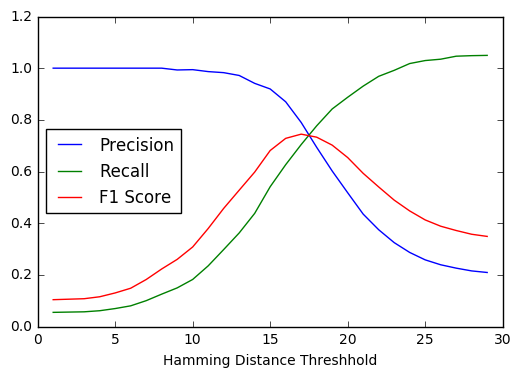

In [5]:
precisions = []
recalls = []
f1s = []
iterations = []

for i in range(1,30):
    p, r, f = performance_metrics(i)
    precisions.append(p)
    recalls.append(r)
    iterations.append(i)
    f1s.append(f)

import matplotlib.pyplot as plt

plt.plot(iterations, precisions, label = 'Precision')
plt.plot(iterations, recalls, label = 'Recall')
plt.plot(iterations, f1s, label = 'F1 Score')
plt.xlabel('Hamming Distance Threshhold')
plt.legend(loc='best')
plt.show()